In [1]:
import numpy as np
from scipy.signal import fftconvolve
from scipy.special import expit

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept import utils

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# use original TimeSeries implementation
class TimeSeries(object):
    def __init__(self, tsample, data):
        """
        Represent a time-series
        """
        self.data = data
        self.tsample = tsample
        self.sampling_rate = 1 / tsample
        self.duration = self.data.shape[-1] * tsample
        self.time = np.linspace(tsample, self.duration, data.shape[-1])
        self.shape = data.shape

    def __getitem__(self, y):
        return TimeSeries(self.tsample, self.data[y])

    def resample(self, factor):
        TimeSeries.__init__(self, self.tsample * factor,
                            self.data[..., ::factor])

In [3]:
def psycho2stim(dur, freq, tsample):
    # for now, keep most params constant except for frequency and overall stimulus duration
    p2pt = e2cm.Psycho2Pulsetrain(freq, dur, pulse_dur=.075/1000, interphase_dur=.075/1000, 
                                  tsample=tsample, current_amplitude=20, pulsetype='cathodicfirst')
    return p2pt

def speedup(data, data_ref):
    # returns a speedup factor for a list of execution times `data` compared to reference data `data_ref`
    return np.mean(data_ref / data)

def percent_faster(data, data_ref):
    # returns how much faster a list of execution times `data` is compared to reference data `data_ref` (%)
    return np.mean((data_ref - data) / data_ref) * 100

In [4]:
# global specs
tsample=.005/1000.
fps = 30
rs = 1/(fps*tsample)

tau1 = .42/1000
tau2 = 45.25/1000
tau3 = 26.25/1000
dojit = True

# pre-calc gamma
t = np.arange(0, 20*tau1, tsample)
gamma1 = e2cm.gamma(1, tau1, t)
t = np.arange(0, 8*tau2, tsample)
gamma2 = e2cm.gamma(1, tau2, t)
t = np.arange(0, 8*tau3, tsample)
gamma3 = e2cm.gamma(3, tau3, t)

In [5]:
# The temporal model contains the cascade of operations that leads from pulse to percept:
tm = ec2b.TemporalModel(tsample=tsample)

In [6]:
# sweep stimulus duration, but keep stimulus frequency fixed
freq=20
num_pts = 11
duration = np.linspace(0.1, 1, num_pts)

In [7]:
# Step 1: Optimize fast response
# ------------------------------

def fr_ref(stim, tau1=.42/1000, dojit=True):
    # fast response: reference implementation
    t = np.arange(0, 20 * tau1, stim.tsample)
    g = e2cm.gamma(1, tau1, t)
    R1 = stim.tsample * utils.sparseconv(g, stim.data, mode='same', dojit=dojit)
    return TimeSeries(stim.tsample, R1)

def fr_prealloc(stim, gamma, dojit=True):
    # pre-allocate gamma function instead of computing it every time step
    R1 = stim.tsample * utils.sparseconv(gamma, stim.data, mode='same', dojit=dojit)
    return TimeSeries(stim.tsample, R1)

def fr_prealloc_numpy(stim, gamma, dojit=True):
    # pre-allocate gamma, don't convert to TimeSeries
    return stim.tsample * utils.sparseconv(gamma, stim.data, mode='same', dojit=dojit)

In [8]:
t_fr_ref = []
t_fr_prealloc = []
t_fr_prealloc_numpy = []

for dur in duration:
    stim = psycho2stim(dur, freq, tsample)

    t0 = %timeit -oq fr_ref(stim, tau1, dojit)
    t1 = %timeit -oq fr_prealloc(stim, gamma1, dojit)
    t2 = %timeit -oq fr_prealloc_numpy(stim, gamma1, dojit)

    t_fr_ref.append(t0.best)
    t_fr_prealloc.append(t1.best)
    t_fr_prealloc_numpy.append(t2.best)

In [9]:
t_fr_ref = np.array(t_fr_ref)
t_fr_prealloc = np.array(t_fr_prealloc)
t_fr_prealloc_numpy = np.array(t_fr_prealloc_numpy)

prealloc:		avg speedup 1.084x		avg 6.9% faster
prealloc + numpy:	avg speedup 1.424x		avg 29.0% faster


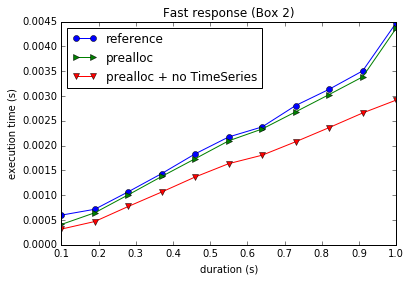

In [10]:
plt.plot(duration, t_fr_ref, '-o', label='reference')
plt.plot(duration, t_fr_prealloc, '->', label='prealloc')
plt.plot(duration, t_fr_prealloc_numpy, '-v', label='prealloc + no TimeSeries')
plt.xlabel('duration (s)')
plt.ylabel('execution time (s)')
plt.legend(loc='upper left')
plt.title('Fast response (Box 2)')

print('prealloc:\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_fr_prealloc, t_fr_ref), 
                                                               percent_faster(t_fr_prealloc, t_fr_ref)))
print('prealloc + numpy:\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_fr_prealloc_numpy, t_fr_ref),
                                                                     percent_faster(t_fr_prealloc_numpy, t_fr_ref)))

In [11]:
# Step 2: Optimize charge accumulation
# ------------------------------------

def ca_ref(fr, ecm, tau2=45.25/1000, epsilon=8.73):
    # charge accumulation, reference implementation
    t = np.arange(0, 8 * tau2, fr.tsample)
    gamma2 = e2cm.gamma(1, tau2, t)

    rect_amp = np.where(ecm.data > 0, ecm.data, 0)  # rectify
    ca = tsample * np.cumsum(rect_amp.astype(float), axis=-1)
    charge_acc = epsilon * fr.tsample * fftconvolve(ca, gamma2, mode='same')
    
    b3 = fr.data - charge_acc
    b3 = np.where(b3 > 0, b3, 0) # rectify again
    return TimeSeries(fr.tsample, b3)

def ca_prealloc(fr, ecm, gamma2, epsilon=8.73):
    # pre-allocate gamma function instead of computing it every time step
    rect_amp = np.where(ecm.data > 0, ecm.data, 0)  # rectify
    ca = tsample * np.cumsum(rect_amp.astype(float), axis=-1)
    charge_acc = epsilon * fr.tsample * fftconvolve(ca, gamma2, mode='same')
    
    b3 = fr.data - charge_acc
    b3 = np.where(b3 > 0, b3, 0) # rectify again
    return TimeSeries(fr.tsample, b3)

def ca_prealloc_numpy(fr, ecm, gamma2, epsilon=8.73):
    # pre-allocate gamma, don't convert to TimeSeries
    rect_amp = np.where(ecm.data > 0, ecm.data, 0)  # rectify
    ca = tsample * np.cumsum(rect_amp.astype(float), axis=-1)
    charge_acc = epsilon * ecm.tsample * fftconvolve(ca, gamma2, mode='same')

    b3 = fr - charge_acc
    return np.where(b3 > 0, b3, 0) # rectify again

def ca_prealloc_numpy_max(fr, ecm, gamma2, epsilon=8.73):
    ca = tsample * np.cumsum(np.maximum(0, ecm.data), axis=-1)
    charge_acc = epsilon * ecm.tsample * fftconvolve(ca, gamma2, mode='same')
    return np.maximum(0, fr - charge_acc)

In [12]:
t_ca_ref = []
t_ca_prealloc = []
t_ca_prealloc_numpy = []
t_ca_prealloc_numpy_max = []

for dur in duration:
    stim = psycho2stim(dur, freq, tsample)
    fr = fr_prealloc(stim, gamma1, dojit)

    t0 = %timeit -oq ca_ref(fr, stim, tau2)
    t1 = %timeit -oq ca_prealloc(fr, stim, gamma2)
    t2 = %timeit -oq ca_prealloc_numpy(fr.data, stim, gamma2)
    t3 = %timeit -oq ca_prealloc_numpy_max(fr.data, stim, gamma2)

    t_ca_ref.append(t0.best)
    t_ca_prealloc.append(t1.best)
    t_ca_prealloc_numpy.append(t2.best)
    t_ca_prealloc_numpy_max.append(t3.best)

In [13]:
t_ca_ref = np.array(t_ca_ref)
t_ca_prealloc = np.array(t_ca_prealloc)
t_ca_prealloc_numpy = np.array(t_ca_prealloc_numpy)
t_ca_prealloc_numpy_max = np.array(t_ca_prealloc_numpy_max)

prealloc:			avg speedup 1.264x		avg 20.0% faster
prealloc + numpy:		avg speedup 1.312x		avg 23.0% faster
prealloc + numpy + max:		avg speedup 1.342x		avg 24.8% faster


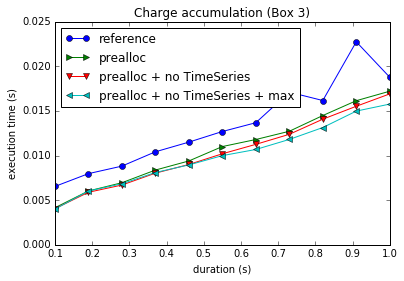

In [14]:
plt.plot(duration, t_ca_ref, '-o', label='reference')
plt.plot(duration, t_ca_prealloc, '->', label='prealloc')
plt.plot(duration, t_ca_prealloc_numpy, '-v', label='prealloc + no TimeSeries')
plt.plot(duration, t_ca_prealloc_numpy_max, '-<', label='prealloc + no TimeSeries + max')
plt.xlabel('duration (s)')
plt.ylabel('execution time (s)')
plt.legend(loc='upper left')
plt.title('Charge accumulation (Box 3)')

print('prealloc:\t\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_ca_prealloc, t_ca_ref), 
                                                               percent_faster(t_ca_prealloc, t_ca_ref)))
print('prealloc + numpy:\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_ca_prealloc_numpy, t_ca_ref),
                                                                     percent_faster(t_ca_prealloc_numpy, t_ca_ref)))
print('prealloc + numpy + max:\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_ca_prealloc_numpy_max, t_ca_ref),
                                                                           percent_faster(t_ca_prealloc_numpy_max, t_ca_ref)))

In [15]:
# Step 3: Optimize stationary nonlinearity
# ----------------------------------------

def sn_ref(stim, asymptote, slope, shift):
    # stationary nonlinearity, reference implementation
    # expects stim to be a TimeSeries object
    R3norm = stim.data / stim.data.max()
    scale_factor = asymptote / (1 + np.exp(-(stim.data / slope) + shift))
    R4 = R3norm * scale_factor
    return TimeSeries(stim.tsample, R4)

def sn_nanduri(stim, asymptote, slope, shift):
    # use exact equation from Nanduri et al. (2012)
    # expects stim to be a TimeSeries object
    scale_factor = asymptote / (1 + np.exp((shift - stim.data.max()) / slope))
    R4 = stim.data / stim.data.max() * scale_factor
    return TimeSeries(stim.tsample, R4)

def sn_nanduri_expit(stim, asymptote, slope, shift):
    # use Nanduri eq. and expit to speed up logistic function
    # expects stim to be a TimeSeries object
    scale_factor = asymptote * expit((stim.data.max() - shift) / slope)
    return TimeSeries(stim.tsample, stim.data / stim.data.max() * scale_factor)

def sn_nanduri_expit_numpy(stim, asymptote, slope, shift):
    # use Nanduri eq., expit, and don't convert to/from TimeSeries object
    # expects stim to be a np.array
    return stim / stim.max() * asymptote * expit((stim.max() - shift) / slope)

In [16]:
t_sn_ref = []
t_sn_nanduri = []
t_sn_nanduri_expit = []
t_sn_nanduri_expit_numpy = []

asymptote = 14
slope = 3
shift = 16

for dur in duration:
    stim = psycho2stim(dur, freq, tsample)
    fr = fr_prealloc(stim, gamma1, dojit)

    t0 = %timeit -oq sn_ref(fr, asymptote, slope, shift)
    t1 = %timeit -oq sn_nanduri(fr, asymptote, slope, shift)
    t2 = %timeit -oq sn_nanduri_expit(fr, asymptote, slope, shift)
    t3 = %timeit -oq sn_nanduri_expit_numpy(fr.data, asymptote, slope, shift)

    t_sn_ref.append(t0.best)
    t_sn_nanduri.append(t1.best)
    t_sn_nanduri_expit.append(t2.best)
    t_sn_nanduri_expit_numpy.append(t3.best)

In [17]:
t_sn_ref = np.array(t_sn_ref)
t_sn_nanduri = np.array(t_sn_nanduri)
t_sn_nanduri_expit = np.array(t_sn_nanduri_expit)
t_sn_nanduri_expit_numpy = np.array(t_sn_nanduri_expit_numpy)

nanduri:			avg speedup 3.968x		avg 74.8% faster
nanduri + expit:		avg speedup 3.973x		avg 74.8% faster
nanduri + expit + numpy:	avg speedup 8.766x		avg 88.6% faster


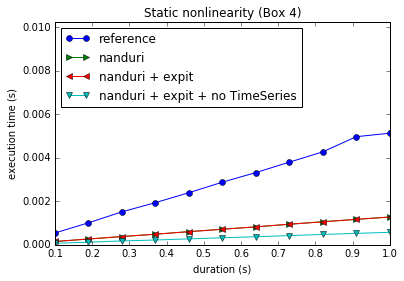

In [18]:
plt.plot(duration, t_sn_ref, '-o', label='reference')
plt.plot(duration, t_sn_nanduri, '->', label='nanduri')
plt.plot(duration, t_sn_nanduri_expit, '-<', label='nanduri + expit')
plt.plot(duration, t_sn_nanduri_expit_numpy, '-v', label='nanduri + expit + no TimeSeries')
plt.xlabel('duration (s)')
plt.ylabel('execution time (s)')
plt.legend(loc='upper left')
plt.title('Static nonlinearity (Box 4)')
plt.axis([duration.min(), duration.max(), 0, t_sn_ref.max()*2])

print('nanduri:\t\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_sn_nanduri, t_sn_ref),
                                                                percent_faster(t_sn_nanduri, t_sn_ref)))
print('nanduri + expit:\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_sn_nanduri_expit, t_sn_ref),
                                                                      percent_faster(t_sn_nanduri_expit, t_sn_ref)))
print('nanduri + expit + numpy:\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_sn_nanduri_expit_numpy, t_sn_ref),
                                                                            percent_faster(t_sn_nanduri_expit_numpy, t_sn_ref)))

In [19]:
# Step 4: Optimize slow response
# ------------------------------

def sr_ref(stim, tau3):
    # slow response, reference implementation
    # expects stim to be a TimeSeries object
    t = np.arange(0, tau3 * 8, stim.tsample)
    g = e2cm.gamma(3, tau3, t)
    c = fftconvolve(stim.data, g)
    return TimeSeries(stim.tsample, stim.tsample * c)

def sr_prealloc(stim, gamma3):
    # pre-allocate gamma function instead of computing it every time step
    c = fftconvolve(stim.data, gamma3, mode='same')
    return TimeSeries(stim.tsample, stim.tsample * c)

def sr_prealloc_numpy(stim, gamma3, tsample):
    # preallocate gamma, first fft arg is longest, don't convert to TimeSeries
    # expects stim to be a np.array
    return tsample * fftconvolve(stim, gamma3, mode='same')

In [20]:
t_sr_ref = []
t_sr_prealloc = []
t_sr_prealloc_numpy = []

for dur in duration:
    stim = psycho2stim(dur, freq, tsample)
    fr = fr_prealloc(stim, gamma1, dojit)
    sn = sn_nanduri_expit(fr, asymptote, slope, shift)

    t0 = %timeit -oq sr_ref(sn, tau3)
    t1 = %timeit -oq sr_prealloc(sn, gamma3)
    t2 = %timeit -oq sr_prealloc_numpy(sn.data, gamma3, tsample)

    t_sr_ref.append(t0.best)
    t_sr_prealloc.append(t1.best)
    t_sr_prealloc_numpy.append(t2.best)

In [21]:
t_sr_ref = np.array(t_sr_ref)
t_sr_prealloc = np.array(t_sr_prealloc)
t_sr_prealloc_numpy = np.array(t_sr_prealloc_numpy)

prealloc:		avg speedup 1.217x		avg 17.2% faster
prealloc + numpy:	avg speedup 1.298x		avg 22.4% faster


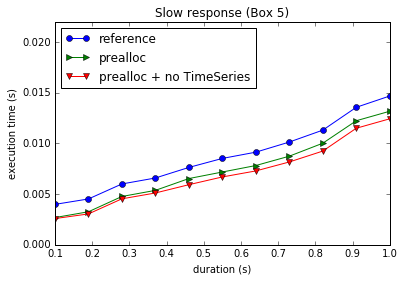

In [22]:
plt.plot(duration, t_sr_ref, '-o', label='reference')
plt.plot(duration, t_sr_prealloc, '->', label='prealloc')
plt.plot(duration, t_sr_prealloc_numpy, '-v', label='prealloc + no TimeSeries')
plt.xlabel('duration (s)')
plt.ylabel('execution time (s)')
plt.legend(loc='upper left')
plt.title('Slow response (Box 5)')
plt.axis([duration.min(), duration.max(), 0, t_sr_ref.max()*1.5])

print('prealloc:\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_sr_prealloc, t_sr_ref),
                                                                  percent_faster(t_sr_prealloc, t_sr_ref)))
print('prealloc + numpy:\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_sr_prealloc_numpy, t_sr_ref),
                                                                             percent_faster(t_sr_prealloc_numpy, t_sr_ref)))

In [23]:
# Step 5: Compare performance across the full cascade
# ---------------------------------------------------

def cascade_ref(ecss, tau1, tau2, tau3, asymptote, slope, shift, dojit):
    fr = fr_ref(ecss, tau1, dojit)
    ca = ca_ref(fr, ecss, tau2)
    sn = sn_ref(ca, asymptote, slope, shift)
    sr = sr_ref(sn, tau3)
    
def cascade_prealloc(ecss, gamma1, gamma2, gamma3, asymptote, slope, shift, dojit):
    fr = fr_prealloc(ecss, gamma1, dojit)
    ca = ca_prealloc(fr, ecss, gamma2)
    sn = sn_nanduri(ca, asymptote, slope, shift)
    sr = sr_prealloc(sn, gamma3)
    
def cascade_all_nanduri(ecss, gamma1, gamma2, gamma3, asymptote, slope, shift, dojit):
    fr = fr_prealloc_numpy(ecss, gamma1, dojit)
    ca = ca_prealloc_numpy_max(fr, ecss, gamma2)
    sn = sn_nanduri_expit_numpy(ca, asymptote, slope, shift)
    sr = sr_prealloc_numpy(sn, gamma3, ecss.tsample)

In [24]:
t_casc_ref = []
t_casc_prealloc = []
t_casc_all_nanduri = []

for dur in duration:
    stim = psycho2stim(dur, freq, tsample)
    
    t0 = %timeit -oq cascade_ref(stim, tau1, tau2, tau3, asymptote, slope, shift, dojit)
    t1 = %timeit -oq cascade_prealloc(stim, gamma1, gamma2, gamma3, asymptote, slope, shift, dojit)
    t2 = %timeit -oq cascade_all_nanduri(stim, gamma1, gamma2, gamma3, asymptote, slope, shift, dojit)

    t_casc_ref.append(t0.best)
    t_casc_prealloc.append(t1.best)
    t_casc_all_nanduri.append(t2.best)

In [25]:
t_casc_ref = np.array(t_casc_ref)
t_casc_prealloc = np.array(t_casc_prealloc)
t_casc_all_nanduri = np.array(t_casc_all_nanduri)

prealloc:		avg speedup 1.309x		avg 23.2% faster
all nanduri:		avg speedup 1.478x		avg 32.3% faster


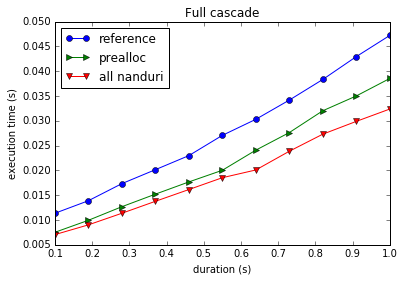

In [26]:
plt.plot(duration, t_casc_ref, '-o', label='reference')
plt.plot(duration, t_casc_prealloc, '->', label='prealloc')
plt.plot(duration, t_casc_all_nanduri, '-v', label='all nanduri')
plt.xlabel('duration (s)')
plt.ylabel('execution time (s)')
plt.legend(loc='upper left')
plt.title('Full cascade')

print('prealloc:\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_casc_prealloc, t_casc_ref),
                                                             percent_faster(t_casc_prealloc, t_casc_ref)))
print('all nanduri:\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_casc_all_nanduri, t_casc_ref),
                                                                  percent_faster(t_casc_all_nanduri, t_casc_ref)))

In [27]:
t_freq_ref = []
t_freq_prealloc = []
t_freq_all_nanduri = []

frequencies = np.linspace(5, 60, 12)

for hz in frequencies:
    stim = psycho2stim(0.5, hz, tsample)
    
    t0 = %timeit -oq cascade_ref(stim, tau1, tau2, tau3, asymptote, slope, shift, dojit)
    t1 = %timeit -oq cascade_prealloc(stim, gamma1, gamma2, gamma3, asymptote, slope, shift, dojit)
    t2 = %timeit -oq cascade_all_nanduri(stim, gamma1, gamma2, gamma3, asymptote, slope, shift, dojit)

    t_freq_ref.append(t0.best)
    t_freq_prealloc.append(t1.best)
    t_freq_all_nanduri.append(t2.best)

In [28]:
t_freq_ref = np.array(t_freq_ref)
t_freq_prealloc = np.array(t_freq_prealloc)
t_freq_all_nanduri = np.array(t_freq_all_nanduri)

prealloc:		avg speedup 1.278x		avg 21.7% faster
all nanduri:		avg speedup 1.416x		avg 29.3% faster


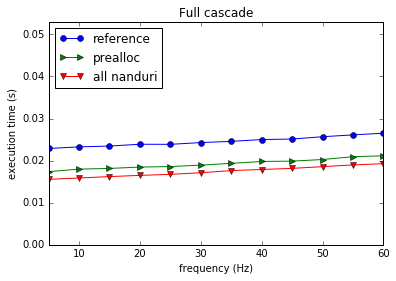

In [29]:
plt.plot(frequencies, t_freq_ref, '-o', label='reference')
plt.plot(frequencies, t_freq_prealloc, '->', label='prealloc')
plt.plot(frequencies, t_freq_all_nanduri, '-v', label='all nanduri')
plt.xlabel('frequency (Hz)')
plt.ylabel('execution time (s)')
plt.legend(loc='upper left')
plt.title('Full cascade')
plt.axis([frequencies.min(), frequencies.max(), 0, t_freq_ref.max()*2])

print('prealloc:\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_freq_prealloc, t_freq_ref),
                                                             percent_faster(t_freq_prealloc, t_freq_ref)))
print('all nanduri:\t\tavg speedup %.3fx\t\tavg %.1f%% faster' % (speedup(t_freq_all_nanduri, t_freq_ref),
                                                                  percent_faster(t_freq_all_nanduri, t_freq_ref)))